In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# imports
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from tqdm import tqdm  
import torchvision.transforms as transforms

import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")

In [5]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
# df = df[["image_name","target"]].sample(3000, random_state=125)

In [7]:
# Dataset
class Melanoma_Dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        length = self.annotations.shape[0]
        return length
    
    def __getitem__(self, idx):
        image_name = self.annotations["image_name"].iloc[idx]
        target = self.annotations["target"].iloc[idx]
        image_path = self.root_dir + "/" + image_name + ".jpg"
        image = img.imread(image_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        target = torch.tensor([target], dtype=torch.float32)
            
        return image, target

In [8]:
batch_size = 80 #80

In [9]:
# vgg_base_state = torch.load("../input/melanoma-prediction-base-model-state-dictionaries/vgg16bn_base_state_dict_new.pt", map_location=device)
# wideresnet_base_state = torch.load("../input/melanoma-prediction-base-model-state-dictionaries/wideresnet50_base_state_dict_new.pt", map_location=device)
# resnext_base_state = torch.load("../input/melanoma-prediction-base-model-state-dictionaries/resnext50_base_state_dict_new.pt", map_location=device)

In [10]:
# base_model = torchvision.models.wide_resnet50_2(pretrained=True)
# torch.save(base_model, "./wide_resnet50_2.pt") # saves to "output"

# vgg16_base_model = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/vgg16_bn.pt")
# vgg19_base_model = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/vgg19_bn.pt")
# wideresnet50_base_model = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/wide_resnet50_2.pt")
# resnext50_base_model = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/resnext50_32x4d.pt")
# resnet152_base_model = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/resnet152.pt")



# vgg16_base_model.load_state_dict(vgg_base_state)
# wideresnet50_base_model.load_state_dict(wideresnet_base_state)
# resnext50_base_model.load_state_dict(resnext_base_state)

# VGG 16 with BatchNorm

In [11]:
vgg16_base_model = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/vgg16_bn.pt")

class VGG16_BatchNorm_base(nn.Module):
    def __init__(self, base_trainable=False):
        super(VGG16_BatchNorm_base, self).__init__()
        
        self.vgg16_base = vgg16_base_model
        
        for param in self.vgg16_base.parameters():
            param.requires_grad = base_trainable
        
        self.fc1 = nn.Linear(1000, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.vgg16_base(x)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# VGG19 with BatchNorm

In [12]:
vgg19_base_model = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/vgg19_bn.pt")

class VGG19_BatchNorm_base(nn.Module):
    def __init__(self, base_trainable=False):
        super(VGG19_BatchNorm_base, self).__init__()
        
        self.vgg19_base = vgg19_base_model
        
        for param in self.vgg19_base.parameters():
            param.requires_grad = base_trainable
        
        self.fc1 = nn.Linear(1000, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.vgg19_base(x)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Wide ResNet 50

In [13]:
wideresnet50_base_model = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/wide_resnet50_2.pt")

class WideResnet50_base(nn.Module):
    def __init__(self, base_trainable=False):
        super(WideResnet50_base, self).__init__()
        
        self.wide_resnet50_base = wideresnet50_base_model
        
        for param in self.wide_resnet50_base.parameters():
            param.requires_grad = base_trainable
        
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.wide_resnet50_base(x)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ResNext50

In [14]:
resnext50_base_model = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/resnext50_32x4d.pt")

class ResNext50_base(nn.Module):
    def __init__(self, base_trainable=False):
        super(ResNext50_base, self).__init__()
        
        self.resnext50_base = resnext50_base_model
        
        for param in self.resnext50_base.parameters():
            param.requires_grad = base_trainable
        
        self.fc1 = nn.Linear(1000, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 750)
        self.fc4 = nn.Linear(750, 500)
        self.fc5 = nn.Linear(500, 100)
        self.fc6 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.resnext50_base(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# ResNet152

In [15]:
resnet152_base_model = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/resnet152.pt")

class ResNet152_base(nn.Module):
    def __init__(self, base_trainable=False):
        super(ResNet152_base, self).__init__()
        
        self.resnet152_base = resnet152_base_model
        
        for param in self.resnet152_base.parameters():
            param.requires_grad = base_trainable
        
        self.fc1 = nn.Linear(1000, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.resnet152_base(x)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# EfficientNet

In [16]:
# # EfficientNet Model built from scratch by Aladdin Persson
# # GitHub code: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_efficientnet.py
# # YouTube Tutorials:
# ## EfficientNet Paper Walkthrough: https://www.youtube.com/watch?v=_OZsGQHB41s
# ## EfficientNet from scratch in Pytorch: https://www.youtube.com/watch?v=fR_0o25kigM


# import torch
# import torch.nn as nn
# from math import ceil

# base_model = [
#     # expand_ratio, channels, repeats, stride, kernel_size
#     [1, 16, 1, 1, 3],
#     [6, 24, 2, 2, 3],
#     [6, 40, 2, 2, 5],
#     [6, 80, 3, 2, 3],
#     [6, 112, 3, 1, 5],
#     [6, 192, 4, 2, 5],
#     [6, 320, 1, 1, 3],
# ]

# # phi_values = {
# #     # tuple of: (phi_value, resolution, drop_rate)
# #     "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
# #     "b1": (0.5, 240, 0.2),
# #     "b2": (1, 260, 0.3),
# #     "b3": (2, 300, 0.3),
# #     "b4": (3, 380, 0.4),
# #     "b5": (4, 456, 0.4),
# #     "b6": (5, 528, 0.5),
# #     "b7": (6, 600, 0.5),
# # }

# phi_values = {
#     # tuple of: (phi_value, resolution, drop_rate)
#     "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
#     "b1": (0.5, 224, 0.2),
#     "b2": (1, 224, 0.3),
#     "b3": (2, 224, 0.3),
#     "b4": (3, 224, 0.4),
#     "b5": (4, 224, 0.4),
#     "b6": (5, 224, 0.5),
#     "b7": (6, 224, 0.5),
# }

# class CNNBlock(nn.Module):
#     def __init__(
#             self, in_channels, out_channels, kernel_size, stride, padding, groups=1
#     ):
#         super(CNNBlock, self).__init__()
#         self.cnn = nn.Conv2d(
#             in_channels,
#             out_channels,
#             kernel_size,
#             stride,
#             padding,
#             groups=groups,
#             bias=False,
#         )
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.silu = nn.SiLU() # SiLU <-> Swish

#     def forward(self, x):
#         return self.silu(self.bn(self.cnn(x)))

# class SqueezeExcitation(nn.Module):
#     def __init__(self, in_channels, reduced_dim):
#         super(SqueezeExcitation, self).__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
#             nn.Conv2d(in_channels, reduced_dim, 1),
#             nn.SiLU(),
#             nn.Conv2d(reduced_dim, in_channels, 1),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         return x * self.se(x)

# class InvertedResidualBlock(nn.Module):
#     def __init__(
#             self,
#             in_channels,
#             out_channels,
#             kernel_size,
#             stride,
#             padding,
#             expand_ratio,
#             reduction=4, # squeeze excitation
#             survival_prob=0.8, # for stochastic depth
#     ):
#         super(InvertedResidualBlock, self).__init__()
#         self.survival_prob = 0.8
#         self.use_residual = in_channels == out_channels and stride == 1
#         hidden_dim = in_channels * expand_ratio
#         self.expand = in_channels != hidden_dim
#         reduced_dim = int(in_channels / reduction)

#         if self.expand:
#             self.expand_conv = CNNBlock(
#                 in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
#             )

#         self.conv = nn.Sequential(
#             CNNBlock(
#                 hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
#             ),
#             SqueezeExcitation(hidden_dim, reduced_dim),
#             nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#         )

#     def stochastic_depth(self, x):
#         if not self.training:
#             return x

#         binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
#         return torch.div(x, self.survival_prob) * binary_tensor

#     def forward(self, inputs):
#         x = self.expand_conv(inputs) if self.expand else inputs

#         if self.use_residual:
#             return self.stochastic_depth(self.conv(x)) + inputs
#         else:
#             return self.conv(x)


# class EfficientNet(nn.Module):
#     def __init__(self, version, num_classes):
#         super(EfficientNet, self).__init__()
#         width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
#         last_channels = ceil(1280 * width_factor)
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.features = self.create_features(width_factor, depth_factor, last_channels)
#         self.classifier = nn.Sequential(
#             nn.Dropout(dropout_rate),
#             nn.Linear(last_channels, num_classes),
#         )

#     def calculate_factors(self, version, alpha=1.2, beta=1.1):
#         phi, res, drop_rate = phi_values[version]
#         depth_factor = alpha ** phi
#         width_factor = beta ** phi
#         return width_factor, depth_factor, drop_rate

#     def create_features(self, width_factor, depth_factor, last_channels):
#         channels = int(32 * width_factor)
#         features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
#         in_channels = channels

#         for expand_ratio, channels, repeats, stride, kernel_size in base_model:
#             out_channels = 4*ceil(int(channels*width_factor) / 4)
#             layers_repeats = ceil(repeats * depth_factor)

#             for layer in range(layers_repeats):
#                 features.append(
#                     InvertedResidualBlock(
#                         in_channels,
#                         out_channels,
#                         expand_ratio=expand_ratio,
#                         stride = stride if layer == 0 else 1,
#                         kernel_size=kernel_size,
#                         padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
#                     )
#                 )
#                 in_channels = out_channels

#         features.append(
#             CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
#         )

#         return nn.Sequential(*features)

#     def forward(self, x):
#         x = self.pool(self.features(x))
#         return self.classifier(x.view(x.shape[0], -1))

# Instantiate Models

In [17]:
vgg16_model = VGG16_BatchNorm_base(base_trainable=False)
vgg19_model = VGG19_BatchNorm_base(base_trainable=False)

wideresnet_model = WideResnet50_base(base_trainable=False)

resnext50_model = ResNext50_base(base_trainable=False)

# ensemble_model = EnsembleModel(trainable=[False, False, False, False])

resnet152_model = ResNet152_base(base_trainable=False)

# b0_model = EfficientNet(version="b0", num_classes=1)#.to(device)
# b1_model = EfficientNet(version="b1", num_classes=1)#.to(device)
# b2_model = EfficientNet(version="b2", num_classes=1)#.to(device)
# b3_model = EfficientNet(version="b3", num_classes=1)#.to(device)
# b4_model = EfficientNet(version="b4", num_classes=1)#.to(device)
# b5_model = EfficientNet(version="b5", num_classes=1)#.to(device)
# b6_model = EfficientNet(version="b6", num_classes=1)#.to(device)
# b7_model = EfficientNet(version="b7", num_classes=1)#.to(device)

# State Dictionaries

#### Loading state dictionaries

In [18]:
vgg16_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/VGG16_bn_model_checkpoint_epoch_7.pt", map_location = "cpu")
vgg19_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/VGG19_bn_model_checkpoint_epoch_6.pt", map_location = "cpu")
wideresnet_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/WideResnet50_model_checkpoint_epoch_7.pt", map_location = "cpu")
resnext50_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/resnext50_model_checkpoint_epoch_8.pt", map_location = "cpu")
# ensemble_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/Ensemble_model_final_checkpoint_epoch_8.pt", map_location = "cpu")
resnet152_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/ResNet152_model_checkpoint_epoch_8.pt", map_location = "cpu")

# load state dicts
vgg16_model.load_state_dict(vgg16_state["model_state"])
vgg19_model.load_state_dict(vgg19_state["model_state"])
wideresnet_model.load_state_dict(wideresnet_state["model_state"])
resnext50_model.load_state_dict(resnext50_state["model_state"])
# ensemble_model.load_state_dict(ensemble_state["model_state"])
resnet152_model.load_state_dict(resnet152_state["model_state"])

# delete state dicts to free up memory
del vgg16_state
del vgg19_state
del wideresnet_state
del resnext50_state
del resnet152_state

# # import states for efficientnet models
# b0_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/EfficientNet Trained Models/EfficientNet_b0_checkpoint_epoch_25.pt", map_location = "cpu")
# b1_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/EfficientNet Trained Models/EfficientNet_b1_checkpoint_epoch_16.pt", map_location = "cpu")
# b2_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/EfficientNet Trained Models/EfficientNet_b2_checkpoint_epoch_20.pt", map_location = "cpu")
# b3_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/EfficientNet Trained Models/EfficientNet_b3_checkpoint_epoch_16.pt", map_location = "cpu")
# b4_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/EfficientNet Trained Models/EfficientNet_b4_checkpoint_epoch_12.pt", map_location = "cpu")
# b5_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/EfficientNet Trained Models/EfficientNet_b5_checkpoint_epoch_19.pt", map_location = "cpu")
# b6_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/EfficientNet Trained Models/EfficientNet_b6_checkpoint_epoch_18.pt", map_location = "cpu")
# b7_state = torch.load("../input/siim-melanoma-trained-models-final/melanoma trained models final/EfficientNet Trained Models/EfficientNet_b7_checkpoint_epoch_13.pt", map_location = "cpu")

# # load state dict
# b0_model.load_state_dict(b0_state["model_state"])
# b1_model.load_state_dict(b1_state["model_state"])
# b2_model.load_state_dict(b2_state["model_state"])
# b3_model.load_state_dict(b3_state["model_state"])
# b4_model.load_state_dict(b4_state["model_state"])
# b5_model.load_state_dict(b5_state["model_state"])
# b6_model.load_state_dict(b6_state["model_state"])
# b7_model.load_state_dict(b7_state["model_state"])

# # delete state dicts from memory
# del b0_state
# del b1_state
# del b2_state
# del b3_state
# del b4_state
# del b5_state
# del b6_state
# del b7_state

In [19]:
# print(ensemble_state["loss"], ensemble_state["auc"])
# print(ensemble_state2["loss"], ensemble_state2["auc"])

#### Loading state weights to models

In [20]:
# vgg16_model.load_state_dict(vgg16_state["model_state"])
# vgg19_model.load_state_dict(vgg19_state["model_state"])

# wideresnet_model.load_state_dict(wideresnet_state["model_state"])

# resnext50_model.load_state_dict(resnext50_state["model_state"])

# # ensemble_model.load_state_dict(ensemble_state["model_state"])

# resnet152_model.load_state_dict(resnet152_state["model_state"])

# b0_model.load_state_dict(b0_state["model_state"])
# b1_model.load_state_dict(b1_state["model_state"])
# b2_model.load_state_dict(b2_state["model_state"])
# b3_model.load_state_dict(b3_state["model_state"])
# b4_model.load_state_dict(b4_state["model_state"])
# b5_model.load_state_dict(b5_state["model_state"])
# b6_model.load_state_dict(b6_state["model_state"])
# b7_model.load_state_dict(b7_state["model_state"])

# Ensemble

In [21]:
class EnsembleModel(nn.Module):
    def __init__(self, trainable=False):
        super(EnsembleModel, self).__init__()
        
        self.wide_resnet50_base = wideresnet_model
        self.vgg16_base = vgg16_model
        self.vgg19_base = vgg19_model
        self.resnext50_base = resnext50_model
        self.resnet152_model = resnet152_model
#         self.b0_model = b0_model
#         self.b1_model = b1_model
#         self.b2_model = b2_model
#         self.b3_model = b3_model
#         self.b4_model = b4_model
#         self.b5_model = b5_model
#         self.b6_model = b6_model
#         self.b7_model = b7_model

        frozen_models = [self.wide_resnet50_base, 
                         self.vgg16_base, 
                         self.vgg19_base, 
                         self.resnext50_base, 
                         self.resnet152_model] 
#                          self.b0_model, 
#                          self.b1_model, 
#                          self.b2_model, 
#                          self.b3_model, 
#                          self.b4_model, 
#                          self.b5_model, 
#                          self.b6_model, 
#                          self.b7_model]
        
        for model in frozen_models:
            for param in model.parameters():
                param.requires_grad = False
        
        # self.fc = nn.Linear(13, 1)
        self.fc = nn.Linear(5, 1)

        self.fc.requires_grad = trainable
        
    def forward(self, x):
        x1 = self.wide_resnet50_base(x)
        x2 = self.vgg16_base(x)
        x3 = self.vgg19_base(x)
        x4 = self.resnext50_base(x) 
        x5 = self.resnet152_model(x) 
#         x6 = self.b0_model(x)
#         x7 = self.b1_model(x)
#         x8 = self.b2_model(x)
#         x9 = self.b3_model(x)
#         x10 = self.b4_model(x)
#         x11 = self.b5_model(x)
#         x12 = self.b6_model(x)
#         x13 = self.b7_model(x)
        
        # x = torch.cat((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13), dim=1)
        x = torch.cat((x1,x2,x3,x4,x5), dim=1)
        
#         x = self.wide_resnet50_base(x)
#         x = torch.cat((x,self.vgg16_base(x)), dim=1)
#         x = torch.cat((x,self.vgg19_base(x)), dim=1)
#         x = torch.cat((x,self.resnext50_base(x)), dim=1)
#         x = torch.cat((x,self.resnet152_model(x)), dim=1)
#         x = torch.cat((x,self.b0_model(x)), dim=1)
#         x = torch.cat((x,self.b1_model(x)), dim=1)
#         x = torch.cat((x,self.b2_model(x)), dim=1)
#         x = torch.cat((x,self.b3_model(x)), dim=1)
#         x = torch.cat((x,self.b4_model(x)), dim=1)
#         x = torch.cat((x,self.b5_model(x)), dim=1)
#         x = torch.cat((x,self.b6_model(x)), dim=1)
#         x = torch.cat((x,self.b7_model(x)), dim=1)
        
        x = self.fc(x)
        return x

#### Send models to device(gpu/cpu)

In [22]:
# vgg16_model = vgg16_model.to(device)
# vgg19_model = vgg19_model.to(device)
# wideresnet_model = wideresnet_model.to(device)
# resnext50_model = resnext50_model.to(device)
# ensemble_model = ensemble_model.to(device)
# resnet152_model = resnet152_model.to(device)

# b0_model = b0_model.to(device)
# b1_model = b1_model.to(device)
# b2_model = b2_model.to(device)
# b3_model = b3_model.to(device)
# b4_model = b4_model.to(device)
# b5_model = b5_model.to(device)
# b6_model = b6_model.to(device)
# b7_model = b7_model.to(device)

# ensemble_state = torch.load("../input/siim-melanoma-trained-models-final/Ensemble_model_2_checkpoint_epoch_9.pt", map_location="cpu")
# model = EnsembleModel(trainable=False)
# model.load_state_dict(ensemble_state["model_state"])
# model = model.to(device)
# # free up ram
# del ensemble_state


model = EnsembleModel(trainable=True).to(device)

In [23]:
# augmentations/transforms
images_mean = (0.8060590931711208, 0.620982283291032, 0.5915027590675953)
images_std = (0.08131081913267031, 0.09455098010432171, 0.10589780296354254)
image_transforms = transforms.Compose(
    [  # Compose makes it possible to have many transforms
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=90),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=images_mean, std=images_std),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=images_mean, std=images_std),
    ]
)

In [24]:
train_df, test_df = train_test_split(df, test_size=0.1) #, random_state=125)

In [25]:
total_samples = len(train_df["target"])
class_1_count = sum(train_df["target"]) + 0.0001 #in case class_1_count is zero
class_0_count = total_samples - class_1_count
class_weights = [total_samples/class_0_count, total_samples/class_1_count]

list_of_weights = [class_weights[i] for i in train_df["target"]]
weighted_sampler = WeightedRandomSampler(list_of_weights, num_samples = len(list_of_weights), replacement=True)

In [26]:
# # Instantiate Datasets and DataLoaders
# # root_directory = "../input/siim-isic-melanoma-classification/jpeg/train"
root_directory = "../input/siimisic-resized-224x224-jpeg/output_train/train"

train_ds = Melanoma_Dataset(train_df, root_dir=root_directory, transform=image_transforms)
test_ds = Melanoma_Dataset(test_df, root_dir=root_directory, transform=image_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, sampler=weighted_sampler,
                          num_workers=1, pin_memory=True) #, shuffle=False) shuffle synonymous with sampler
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, 
                         num_workers=1, pin_memory=True, shuffle=True)

In [27]:
# Focal Loss Function
# from this blog post: https://amaarora.github.io/2020/06/29/FocalLoss.html

class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).to(device)  #.cuda() #remember to define "device"
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [50]:
loss_function = WeightedFocalLoss(alpha=0.25, gamma=2.0)

# from abishek thakur: https://www.kaggle.com/abhishek/melanoma-detection-with-pytorch?scriptVersionId=35193166
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       patience=3, 
                                                       threshold=0.001, 
                                                       mode="min"
                                                      )

In [29]:
import math

# # from documentation: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    print(f"Total samples: {size}")
    print(f"Batch size: {batch_size}")
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        
        X = X.to(device=device)
        y = y.to(device=device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         scheduler.step(loss)
        print(f"Batch number: {batch+1}/{math.ceil(size/batch_size)}", end="\r")
    
    print("\n")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    
    model.eval()
    
    predictions = []
    targets = []
    with torch.no_grad():
        for X, y in dataloader:
            
            X = X.to(device=device)
            y = y.to(device=device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
            predictions.append(pred.cpu())
            targets.append(y.cpu())
    
    predictions = np.vstack(predictions).ravel()
    targets = np.vstack(targets).ravel() #test_df["target"].values
    auc = sklearn.metrics.roc_auc_score(targets, predictions)

    test_loss /= size
#     auc /= size
    # print(f"Avg loss: {test_loss:>8f} \n")
    print(f"Avg loss: {test_loss}, AUC = {auc} \n")
    
    return test_loss, auc

In [30]:
def train_model(model, train_loader, test_loader, loss_function, optimizer, epochs=5, epochs_pretrained=0):
    # lowest_loss = np.inf #float("inf")
    top_3_models = []
    for t in range(epochs):
        print(f"Epoch {t+1}[{epochs_pretrained+t+1} in total]\n-------------------------------")
#         if device == "cuda":
#             train_loop_amp(train_loader, model, loss_function, optimizer)
#         else:
#             train_loop(train_loader, model, loss_function, optimizer)


        train_loop(train_loader, model, loss_function, optimizer)
        test_loss, test_auc = test_loop(test_loader, model, loss_function)
        
        scheduler.step(test_loss)
        # saving model checkpoint
        checkpoint = {"epoch": epochs_pretrained+t+1, 
                      "model_state": model.state_dict(), 
                      "optimizer_state": optimizer.state_dict(),
                      "scheduler_state": scheduler.state_dict(), 
                      "loss": test_loss, 
                      "auc": test_auc}
        
        save_location = f"./Ensemble_model_2_checkpoint_epoch_{epochs_pretrained+t+1}.pt"
        
        # always save on first epoch
        if len(top_3_models) == 0:
            torch.save(checkpoint, save_location)
            top_3_models.append({"filename": save_location, 
                                 "loss": test_loss})
        
        # save if loss is lower than highest/worst loss of saved models
        if test_loss < top_3_models[0]["loss"]:
            torch.save(checkpoint, save_location)
            top_3_models.append({"filename": save_location, 
                                 "loss": test_loss})
        
        # removes worst performing model, but only if there are 3 or more models already saved
        # keeps the 3 best models(measured by loss on validation set)
        if len(top_3_models) > 3:
            file_to_remove = top_3_models[0]["filename"]
            os.remove(file_to_remove)
            top_3_models.pop(0)

        # sort in descending order by loss 
        top_3_models = sorted(top_3_models, key=lambda k: k["loss"], reverse=True)
            
        # print(f"top_3_models length: {len(top_3_models)}")
        
        # always save last epoch
        if t == epochs-1:
            torch.save(checkpoint, save_location)
            top_3_models.append({"filename": save_location, 
                                 "loss": test_loss})
            
    print("Done!")
    
    return model

In [51]:
model = train_model(model, train_loader, test_loader, loss_function, optimizer, 
                    epochs=2, epochs_pretrained=0)

Epoch 1[1 in total]
-------------------------------
Total samples: 29813
Batch size: 80
Batch number: 373/373

Avg loss: 9.83025810357724e-05, AUC = 0.9927912695972948 

Done!


In [52]:
def get_predictions(dataloader, model):
    predictions = []
    targets = []
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device=device)
            pred = model(X)
            predictions.append(pred.cpu())
            targets.append(y.cpu())
    
    predictions = np.vstack(predictions).ravel()
    targets = np.vstack(targets).ravel()
            
    return predictions, targets


def predict_multiple_epochs(dataloader, model, epochs=1):

    predictions = []
    targets = []
    model.eval()
    
    for i in range(epochs):
        print(f"Epoch: {i+1}")
        pred, targ = get_predictions(dataloader, model)
        predictions.append(pred)
        if i == 0:
            targets.append(targ)
            
    targets = np.array(targets).ravel()
    predictions = np.mean(predictions, axis=0)

    return predictions, targets

In [53]:
# Reset test loader with batch_size=1
# so that we can use our predict_multiple_epochs function
# to perform test-time augmentation
test_loader_new = DataLoader(dataset=test_ds, batch_size=128, 
                             num_workers=1, pin_memory=True, shuffle=False)

In [54]:
predictions, targets = predict_multiple_epochs(test_loader_new, model, epochs=1)

Epoch: 1


In [55]:
print(f"AUC: {sklearn.metrics.roc_auc_score(targets, predictions)}")

AUC: 0.9934880623014654


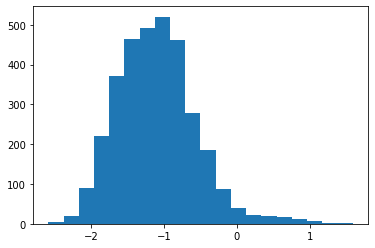

In [56]:
plt.hist(predictions, bins=20)#, range=(0,1))
plt.show()

In [57]:
filtered_predictions = []
for pred in predictions:
    if pred < 0:
        filtered_predictions.append(0)
    else:
        filtered_predictions.append(1)

In [58]:
test_labels = test_df["target"].values

In [59]:
print(classification_report(test_labels, filtered_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3253
           1       0.53      0.92      0.67        60

    accuracy                           0.98      3313
   macro avg       0.77      0.95      0.83      3313
weighted avg       0.99      0.98      0.99      3313



Text(0.5, 1.0, 'Confusion Matrix')

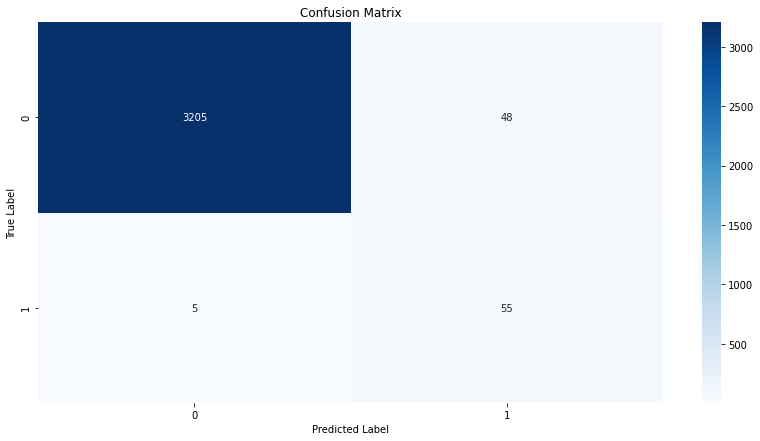

In [60]:
conf_matrix = confusion_matrix(test_labels, filtered_predictions)

plt.figure(figsize=(14,7))
sns.heatmap(conf_matrix, annot=True, cbar=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Predicting on the Test set

In [61]:
testing_df = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")

In [62]:
testing_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [63]:
# testing_df = testing_df.sample(3000)

In [64]:
# Test Dataset class: Test set doesn't have a target
class Melanoma_Test_Dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        length = self.annotations.shape[0]
        return length
    
    def __getitem__(self, idx):
        image_name = self.annotations["image_name"].iloc[idx]
        image_path = self.root_dir + "/" + image_name + ".jpg"
        image = img.imread(image_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image

In [65]:
# augmentations/transforms
images_mean = (0.8060590931711208, 0.620982283291032, 0.5915027590675953)
images_std = (0.08131081913267031, 0.09455098010432171, 0.10589780296354254)
image_transforms = transforms.Compose(
    [  # Compose makes it possible to have many transforms
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=90),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=images_mean, std=images_std),
    ]
)


# test_transforms = transforms.Compose(
#     [
#         transforms.ToPILImage(),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=images_mean, std=images_std),
#     ]
# )

In [66]:
root_directory = "../input/siimisic-resized-224x224-jpeg/output_test/test"


test_ds_new = Melanoma_Test_Dataset(testing_df, root_dir=root_directory, transform=image_transforms) #image_transforms)
test_loader_new = DataLoader(dataset=test_ds_new, batch_size=256, num_workers=1, pin_memory=True, shuffle=False)


In [67]:
# import matplotlib.image as img
# import matplotlib.pyplot as plt

# image = img.imread(test_ds_new[28])
# plt.imshow(test_ds_new[375].permute(1, 2, 0))#image)

In [68]:
def get_predictions(dataloader, model):
    predictions = []
    #targets = []
    model.eval()

    with torch.no_grad():
        for X in dataloader:
            X = X.to(device=device)
            pred = model(X)
            predictions.append(pred.cpu())
            #targets.append(y.cpu())
    
    predictions = np.vstack(predictions).ravel()
    #targets = np.vstack(targets).ravel()
            
    return predictions

def predict_multiple_epochs(dataloader, model, epochs=1): #test_df, model, epochs=1):
    # Note: must use dataloader with batch_size=1
    predictions = []
    #targets = []
    model.eval()
    
    for i in range(epochs):
        print(f"Epoch: {i+1}")
        
#         test_ds_new = Melanoma_Test_Dataset(test_df, root_dir=root_directory, transform=image_transforms) #image_transforms)
#         test_loader_new = DataLoader(dataset=test_ds_new, batch_size=1, num_workers=1, pin_memory=True, shuffle=False)
        
        pred = get_predictions(dataloader, model)
        predictions.append(pred)
#         if i == 0:
#             targets.append(targ)
            
    #targets = np.array(targets).ravel()
    predictions = np.mean(predictions, axis=0)
    
    print("Done!")
    print("///")

    return predictions

In [69]:
predictions = predict_multiple_epochs(test_loader_new, model, epochs=3)

Epoch: 1
Epoch: 2
Epoch: 3
Done!
///


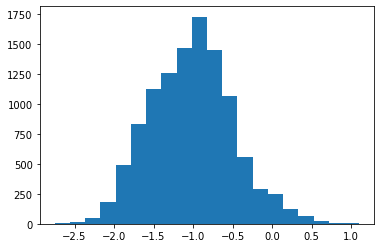

In [70]:
plt.hist(predictions, bins=20)#, range=(0,1))
plt.show()

In [71]:
image_labels = testing_df["image_name"].tolist()

predictions_dictionary= {
    "image_name": image_labels, 
    "target": predictions,
}

predictions_df = pd.DataFrame(predictions_dictionary)

In [72]:
predictions_df.head()

,image_name,target
0,ISIC_0052060,-1.533546
1,ISIC_0052349,-2.092326
2,ISIC_0058510,-1.834634
3,ISIC_0073313,-1.760471
4,ISIC_0073502,-0.626001


In [73]:
predictions_df.to_csv("predictions_ensemble2_v3.csv", index=False)

In [74]:
pred_tensor = torch.Tensor(predictions)
pred = torch.sigmoid(pred_tensor)

pred = pred.cpu().numpy()

predictions_dictionary_sigmoid= {
    "image_name": image_labels, 
    "target": pred,
}

predictions_df_sigmoid = pd.DataFrame(predictions_dictionary_sigmoid)

predictions_df_sigmoid.to_csv("predictions_ensemble2_v3_sigmoid.csv", index=False)

In [75]:
predictions_df_sigmoid.head()

,image_name,target
0,ISIC_0052060,0.177475
1,ISIC_0052349,0.109845
2,ISIC_0058510,0.137687
3,ISIC_0073313,0.146731
4,ISIC_0073502,0.348418


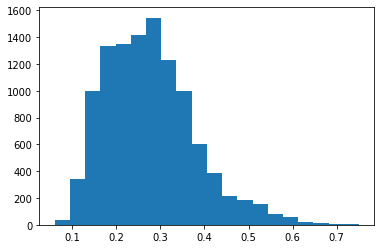

In [76]:
plt.hist(pred, bins=20)#, range=(0,1))
plt.show()